<a href="https://colab.research.google.com/github/russell-ai/topic-covid/blob/main/tweet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Twitter


# load data

In [ ]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id file_dst

downloader = Downloader(download_with_pydrive)

In [ ]:
#https://drive.google.com/file/d/1sjtke6Y_3wMlBQoYCHoANQu7Fj7l7rrn/view?usp=share_link

In [ ]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "data")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'tweet_data.csv')

In [ ]:
downloader.download_file("1sjtke6Y_3wMlBQoYCHoANQu7Fj7l7rrn", file_dst=model_path)

### fetching data as dataframe

In [ ]:
import pandas as pd
df = pd.read_csv("/data/tweet_data.csv")
df.head()

,Tweet_Id,Tweet
0,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...
1,1.598104e+18,"Apparently ""I've had COVID for over a week and..."
2,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...
3,1.598103e+18,They're dropping the sequel to COVID baby wooo...
4,1.598101e+18,@1goodtern They drop dead one by one of post C...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446216 entries, 0 to 446215
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Tweet_Id  446216 non-null  float64
 1   Tweet     446216 non-null  object 
dtypes: float64(1), object(1)
memory usage: 6.8+ MB


# Setting up and loading model

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 5.8 MB 7.0 MB/s 
     |████████████████████████████████| 7.6 MB 72.2 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
hf_token = open("/content/drive/MyDrive/token.txt").read()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Setting pipeline for prediction

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device="cuda:0")
sentiment_task("Covid cases are increasing fast!")


[{'label': 'negative', 'score': 0.7235767841339111}]

# feeding pipeline with dataset

### faster with swifter

In [ ]:
#! pip install swifter # first time installation
#! pip install swifter[groupby] # first time installation including dependency for groupby.apply functionality

In [ ]:
import swifter
import numpy as np

In [ ]:
def sent_analysis(s):
  try:
    result = sentiment_task(s)
    label = result[0]["label"]
    score = result[0]["score"]
  except:
    label = np.nan
    score = np.nan
  return label,score


## prediction time

In [ ]:
df["sentiment_analysis"] = df["Tweet"].swifter.apply(lambda x: sent_analysis(x))

Pandas Apply:   0%|          | 0/446216 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
df.head()

,Tweet_Id,Tweet,sentiment_analysis,sentiment,score
0,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,"(negative, 0.8987942934036255)",negative,0.898794
1,1.598104e+18,"Apparently ""I've had COVID for over a week and...","(negative, 0.5844972133636475)",negative,0.584497
2,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,"(negative, 0.7049756646156311)",negative,0.704976
3,1.598103e+18,They're dropping the sequel to COVID baby wooo...,"(neutral, 0.5086733102798462)",neutral,0.508673
4,1.598101e+18,@1goodtern They drop dead one by one of post C...,"(negative, 0.47382649779319763)",negative,0.473826


In [ ]:
df["sentiment"] = df["sentiment_analysis"].swifter.apply(lambda x:x[0])

Pandas Apply:   0%|          | 0/446216 [00:00<?, ?it/s]

In [ ]:
df["score"] = df["sentiment_analysis"].swifter.apply(lambda x:x[1])

Pandas Apply:   0%|          | 0/446216 [00:00<?, ?it/s]

In [ ]:
df.head(20)

,Tweet_Id,Tweet,sentiment_analysis,sentiment,score
0,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,"(negative, 0.8987942934036255)",negative,0.898794
1,1.598104e+18,"Apparently ""I've had COVID for over a week and...","(negative, 0.5844972133636475)",negative,0.584497
2,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,"(negative, 0.7049756646156311)",negative,0.704976
3,1.598103e+18,They're dropping the sequel to COVID baby wooo...,"(neutral, 0.5086733102798462)",neutral,0.508673
4,1.598101e+18,@1goodtern They drop dead one by one of post C...,"(negative, 0.47382649779319763)",negative,0.473826
5,1.598101e+18,@DesertCamel77 @Kate_DowlingNZ But they are ta...,"(negative, 0.811675488948822)",negative,0.811675
6,1.598100e+18,@alex_kuron @Revolve63870109 @stetzor @scrowde...,"(negative, 0.8179773688316345)",negative,0.817977
7,1.598099e+18,Only ungodly people would vote for the racist ...,"(negative, 0.9150388836860657)",negative,0.915039
8,1.598098e+18,"My friend spencer has covid, good thing he ate...","(positive, 0.48467978835105896)",positive,0.484680
9,1.598097e+18,@BrockRiddickIFB I was open about it with the ...,"(negative, 0.5652447938919067)",negative,0.565245


### count the number of tweets

In [ ]:
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)


sentiment
negative    240654
neutral     160298
positive     45263
dtype: int64


### visualize each sentiment

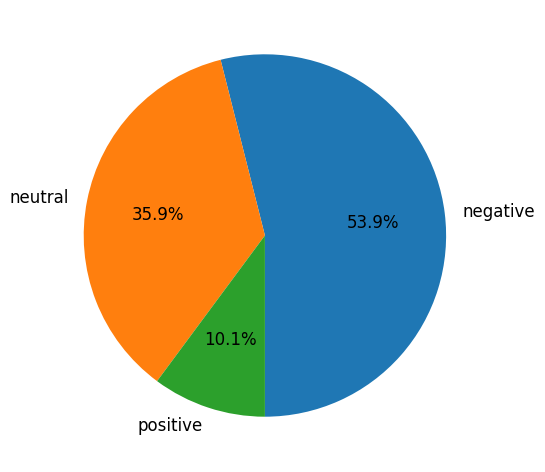

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446216 entries, 0 to 446215
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Tweet_Id            446216 non-null  float64
 1   Tweet               446216 non-null  object 
 2   sentiment_analysis  446216 non-null  object 
 3   sentiment           446215 non-null  object 
 4   score               446215 non-null  float64
dtypes: float64(2), object(3)
memory usage: 17.0+ MB


## saving analysed dataset

In [45]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/PROJECTS/TOPIC-COVID/sent_tweet_data.csv", index=False)

source: [sentiment modelling  ](https://huggingface.co/blog/sentiment-analysis-twitter)



```
russell-ai
```




